## Exploratory Data Analysis

In [220]:
# Import basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Import Sparksession
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

import warnings
warnings.filterwarnings('ignore')

spark = SparkSession.builder.appName("E-Commerce EDA")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","10g")\
        .getOrCreate()

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [2]:
# Function to get shape of the data
def data_shape(data):
    """return the number of rows & cols"""
    n_rows = data.count()
    n_cols = len(data.columns)

    return n_rows, n_cols

In [221]:
# Load order data from directory and print the shape
order_df = spark.read.csv('Dataset/orders.csv',
                    header=True,
                    inferSchema=True,
                    escape="\"")

print('Data shape:', data_shape(order_df))
order_df.show(5)

Data shape: (185013, 9)
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+
|        579|         Silver|            01-Jan-17|    07-Jan-17|123002578|220101400106|               2|                             92.6|               20.7|
|       7574|         SILVER|            01-Jan-17|    05-Jan-17|123004074|210201000009|               1|                             21.7|               9.95|
|      28861|           Gold|            01-Jan-17|    04-Jan-17|123000871|230100500068|               1|                              1.7|                0.8|
|      43796|   

In [4]:
# Display the schema
order_df.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Date Order was placed: string (nullable = true)
 |-- Delivery Date: string (nullable = true)
 |-- Order ID: integer (nullable = true)
 |-- Product ID: long (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Total Retail Price for This Order: double (nullable = true)
 |-- Cost Price Per Unit: double (nullable = true)



##### Data Descriptions:

1. Number of Instances: 185013
2. Attributes:
    - Customer ID: The unique identification code for every customer
    - Customer Status: The membership status categories for each customer consist of Silver, Gold, and Platinum.
    - Date Order was placed: This field records the date on which a customer's order was placed. It represents the moment when a customer initiated a purchase or transaction.
    - Delivery Date: This field records the date on which an order was delivered to the customer. It represents the actual day when the customer received their order.
    - Order ID: The unique identification code for every order of customer purchased
    - Product ID: The unique identification code for every product
    - Quantity Ordered: Represents the number of units of a product or items that a customer ordered as part of a single purchase transaction.
    - Total Retail Price for This Order: This field represents the total retail price of all the items in a customer's order. 
    - Cost Price Per Unit: This field represents the cost price of a single unit of a product or item. It indicates how much the business pays for each item before markup or profit.


Before moving to the next stage, we perform data preprocessing. Because, from the data we can see, there are some data types that are not appropriate, such as "Date Order was placed" and "date delivery." Therefore, we cast them to the date data type. Additionally, we introduce some supplementary attributes to support our analysis, such as calculating profit and item retail price to observe the selling price after the cost per item. And we correct the data inconsistency in the customer status to a capitalized string format.

In [222]:
# Preprocessing data in accordance with the previous explanation.
order_df = (order_df
            .withColumn("Date Order was placed", to_date(col("Date Order was placed"), "dd-MMM-yy"))
            .withColumn("Delivery Date", to_date(col("Delivery Date"), "dd-MMM-yy"))
            .withColumn("Year", year("Date Order was placed"))
            .withColumn("Month", month("Date Order was placed"))
            .withColumn("Customer Status", initcap("Customer Status"))
            .withColumn("Retail Price", col("Total Retail Price for This Order")/col("Quantity Ordered"))
            .withColumn("Profit", round(col("Total Retail Price for This Order") - \
                        (col("Cost Price Per Unit")*col("Quantity Ordered")), 2)))

order_df.show(10)

+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|Customer ID|Customer Status|Date Order was placed|Delivery Date| Order ID|  Product ID|Quantity Ordered|Total Retail Price for This Order|Cost Price Per Unit|Year|Month|Retail Price|Profit|
+-----------+---------------+---------------------+-------------+---------+------------+----------------+---------------------------------+-------------------+----+-----+------------+------+
|        579|         Silver|           2017-01-01|   2017-01-07|123002578|220101400106|               2|                             92.6|               20.7|2017|    1|        46.3|  51.2|
|       7574|         Silver|           2017-01-01|   2017-01-05|123004074|210201000009|               1|                             21.7|               9.95|2017|    1|        21.7| 11.75|
|      28861|           Gold|           2017-

In [6]:
# Load product_supplier data from directory and print the shape
product_df = spark.read.csv('Dataset/product_supplier.csv',
                    header=True,
                    inferSchema=True,
                    escape="\"")

product_df.show(5)

+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|  Product ID|Product Line| Product Category|       Product Group|        Product Name|Supplier Country|       Supplier Name|Supplier ID|
+------------+------------+-----------------+--------------------+--------------------+----------------+--------------------+-----------+
|210100100001|    Children|Children Outdoors|Outdoor things, Kids|Boy's and Girl's ...|              NO|Scandinavian Clot...|         50|
|210100100002|    Children|Children Outdoors|Outdoor things, Kids|   Children's Jacket|              ES| Luna sastreria S.A.|       4742|
|210100100003|    Children|Children Outdoors|Outdoor things, Kids|Children's Jacket...|              NO|Scandinavian Clot...|         50|
|210100100004|    Children|Children Outdoors|Outdoor things, Kids| Children's Rain Set|              NO|Scandinavian Clot...|         50|
|210100100005|    Children|Childre

### Describe Company from Revenue, Profit, Order and Customer by Year

In [68]:
customer_window = Window.partitionBy('Customer ID').orderBy('Date Order was placed')

customer_first_order = (order_df
                            .select('Customer ID', 'Date Order was placed', 'Year')
                            .withColumn('Rank', row_number().over(customer_window))
                            .filter('Rank = 1')
                            .groupBy('Year')
                            .agg(count('Customer ID').alias('Customer Growth'))
                        )

company_sum_year = (order_df
    .groupBy('Year')
    .agg(round(sum('Total Retail Price for This Order'),2).alias('Total Revenue'),
         count('Order ID').alias('Total Order'),
         round(sum('Profit'),2).alias('Total Profit'))
    .join(customer_first_order['Year', 'Customer Growth'], 'Year', 'inner')
    .orderBy('Year')
)

company_sum_year.show()

+----+-------------+-----------+------------+---------------+
|Year|Total Revenue|Total Order|Total Profit|Customer Growth|
+----+-------------+-----------+------------+---------------+
|2017|   4054304.53|      29549|  2159806.13|          19311|
|2018|   4820401.71|      34692|  2555446.28|          14600|
|2019|   5845473.48|      42306|  3101457.98|          10521|
|2020|   4984815.93|      35901|  2650702.81|           6493|
|2021|   5936507.66|      42565|   3151000.9|           5102|
+----+-------------+-----------+------------+---------------+



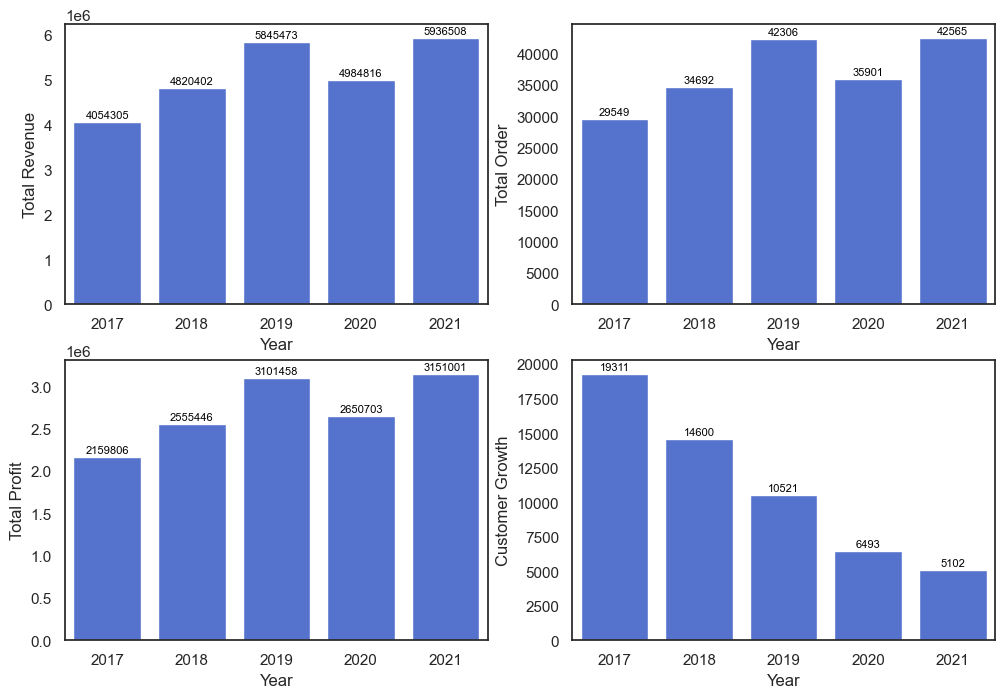

In [179]:
sns.set_theme(style="white")

fig_1 = company_sum_year.toPandas()

# Define the columns and corresponding plot positions
columns = fig_1.columns[1:]

# Create subplots and plot the data for each column
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, column in enumerate(columns):
    row, col = divmod(i, 2)  # Calculate the row and column for the subplot
    ax = sns.barplot(x='Year', y=column, data=fig_1, ax=axes[row, col], color='royalblue')
    
    # Add annotations to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
plt.show()

From the graph, it can be observed that the total revenue experienced a normal fluctuation in the year 2020, likely due to the initial impact of Covid-19. However, it showed a resurgence in 2021. The same pattern can be seen with total orders and total profits. Nevertheless, the annual customer growth of the company has been declining, indicating a significant occurrence of repeat orders from existing customers.

### Find the patterns for Month-Over-Month change in sales for the latest year

In [98]:
revenue_per_month = (
    order_df
        .groupBy(['Year', 'Month'])
        .agg(round(sum('Total Retail Price for This Order'),2).alias('total_sales'))
        .sort(['Year', 'Month'], ascending=[True, True])
)

In [144]:
revenue_window = Window.partitionBy('Year').orderBy('Month')

sales_change = (
    revenue_per_month
        .withColumn('prev_total_Sales', 
                    lag(col('total_sales')).over(revenue_window))
        .withColumn("diff_total_sales", 
                    when(isnull(col('total_sales')-col('prev_total_sales')), 0)
                    .otherwise(col('total_sales')-col('prev_total_sales')))
        .withColumn("pct_change_total_sales", 
                    when(isnull(col('diff_total_sales')/col('prev_total_sales')), 0.0)
                    .otherwise(100.0 * col('diff_total_sales')/col('prev_total_sales')))
        .withColumn("pct_change_total_sales", round(col('pct_change_total_sales'), 2))
        .withColumn("Year-Month", concat_ws("-", *["Year", "Month"]))
        .filter(col('Year') == revenue_per_month.agg(max("Year")).first()[0])
        .select(['Year-Month', 'total_sales', 'pct_change_total_sales'])
)

sales_change.show()

+----------+-----------+----------------------+
|Year-Month|total_sales|pct_change_total_sales|
+----------+-----------+----------------------+
|    2021-1|  422961.34|                   0.0|
|    2021-2|  336529.27|                -20.43|
|    2021-3|  279331.89|                 -17.0|
|    2021-4|  454806.35|                 62.82|
|    2021-5|  512668.84|                 12.72|
|    2021-6|  642173.51|                 25.26|
|    2021-7|  664787.09|                  3.52|
|    2021-8|   658272.6|                 -0.98|
|    2021-9|  313872.49|                -52.32|
|   2021-10|  328082.13|                  4.53|
|   2021-11|   392866.0|                 19.75|
|   2021-12|  930156.13|                136.76|
+----------+-----------+----------------------+



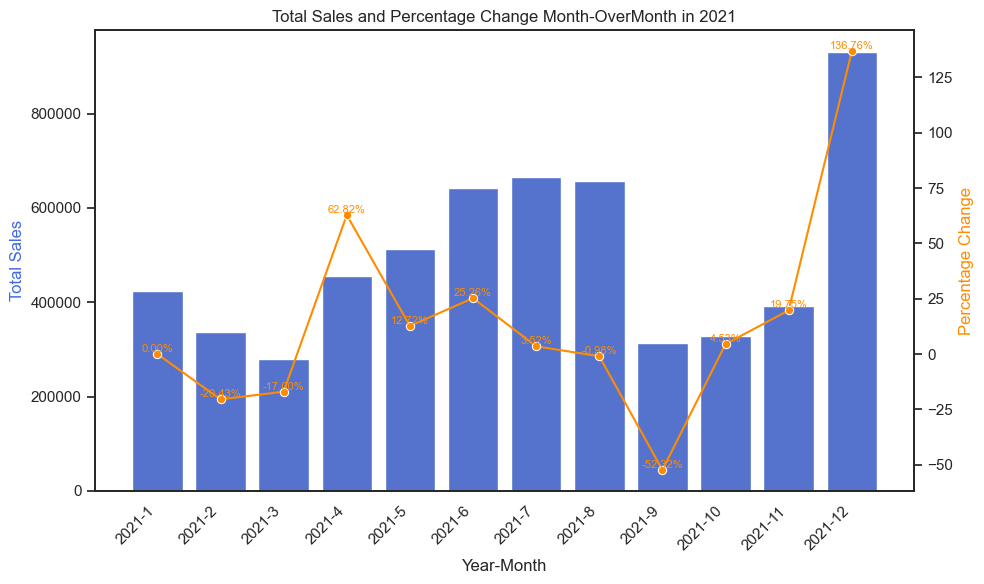

In [168]:
fig_2 = sales_change.toPandas()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot for 'total_sales'
sns.barplot(x='Year-Month', y='total_sales', data=fig_2, ax=ax, color='royalblue')

# Create a second y-axis for the line plot
ax2 = ax.twinx()

# Plot the line chart
sns.lineplot(x='Year-Month', y='pct_change_total_sales', data=fig_2, ax=ax2, color='darkorange', marker='o')

# Add annotations to the pct_change_total_sales
for i, row in fig_2.iterrows():
    ax2.text(i, row['pct_change_total_sales'], f'{row["pct_change_total_sales"]:.2f}%', 
             ha='center', va='bottom', fontsize=8, color='darkorange')
    
# Set labels and titles
ax.set_xlabel('Year-Month')
ax.set_ylabel('Total Sales', color='royalblue')
ax2.set_ylabel('Percentage Change', color='darkorange')
ax.set_title(f'Total Sales and Percentage Change Month-OverMonth in {revenue_per_month.agg(max("Year")).first()[0]}')

# Rotate the x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the plot
plt.tight_layout()
plt.show()

As we can see from the graph:
- The highest total sales occurred in December, at abouve $900,000. This could be due to a variety of factors, such as holiday shopping.
- The lowest total sales occurred in March, at around $200,000. Further data would be needed to understand why this dip occurred.
- The percentage change shows that growth has been relatively steady, with a few spikes in certain months. This suggests that while sales have generally been increasing, there have been a few particularly strong months of growth.

Conclusion: This is very useful for tracking sales performance over time and identifying trends or patterns that might inform future business decisions. For example, if certain months consistently show strong sales, a business might choose to focus their marketing efforts during these times to maximize revenue. Conversely, if certain months consistently show weak sales, a business might look into why this is happening and what they can do to improve.

### Generate the total profit per month over the years

In [142]:
avg_profit_per_month = (
    order_df
        .groupBy('Year')
        .pivot('Month')
        .agg(round(sum('Profit'),2))
        .sort('Year', ascending=True)
)

avg_profit_per_month.show()

+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|Year|        1|        2|        3|        4|        5|        6|        7|        8|        9|       10|       11|       12|
+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|2017|153909.79|129366.52|120167.13|167710.82|199645.34|251354.17|251472.57|248404.12|112842.73|114810.39|123789.79|286332.76|
|2018|194191.74|171451.95|143321.44|210249.63|235697.52|299586.31|293459.02|280581.83|126402.78|131107.86|150603.39|318792.81|
|2019| 228332.4|178623.29|175367.26|249158.86|280930.36|363127.17|360574.94|368132.45|172742.85| 161674.3|187319.78|375474.32|
|2020| 195579.2|165642.53|147670.29|211222.44|245290.48|305579.47|304995.39| 296333.1| 134534.4|143858.84|163874.75|336121.92|
|2021| 228526.6|180991.77|149698.21|238447.93| 273397.5|337451.86|349282.53|346182.14|167139.59|174950.06|21101

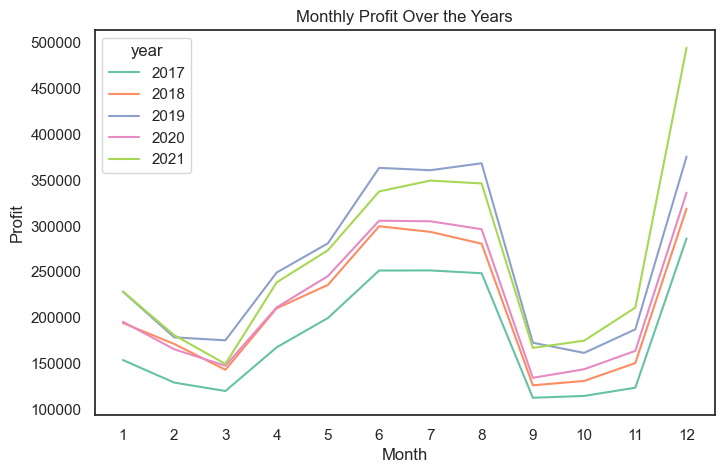

In [248]:
fig_3 = avg_profit_per_month.toPandas()

# Melt the DataFrame to have 'Year', 'Month' and 'Profit' columns
profit_mom_melt = fig_3.melt(id_vars='Year', \
                                        var_name='Month', \
                                        value_name='Profit')
# Assign columns to year, month and profit
profit_mom_melt.columns = ['year', 'month', 'profit']

# Create a line plot
plt.figure(figsize=(8, 5))
sns.lineplot(x='month', y='profit', hue='year', data=profit_mom_melt, palette='Set2')

# Set the title and labels
plt.title('Monthly Profit Over the Years')
plt.xlabel('Month')
plt.ylabel('Profit')

# Show the plot
plt.show()

From the graph, it’s evident that the company’s profit has been on an upward trajectory over the years, with a significant surge in 2021. The lines for 2017, 2018, and 2019 are relatively stable, with minor fluctuations. Although the year 2019 had the highest profit from February to August but, starting from the 9th month of 2021, there’s a noticeable increase in profit.

This could indicate successful business strategies or favorable market conditions in 2021. It’s also possible that certain products or services introduced in this period contributed to this growth. Further data would be needed to confirm these hypotheses.

### What are the top-highest profit product categories?

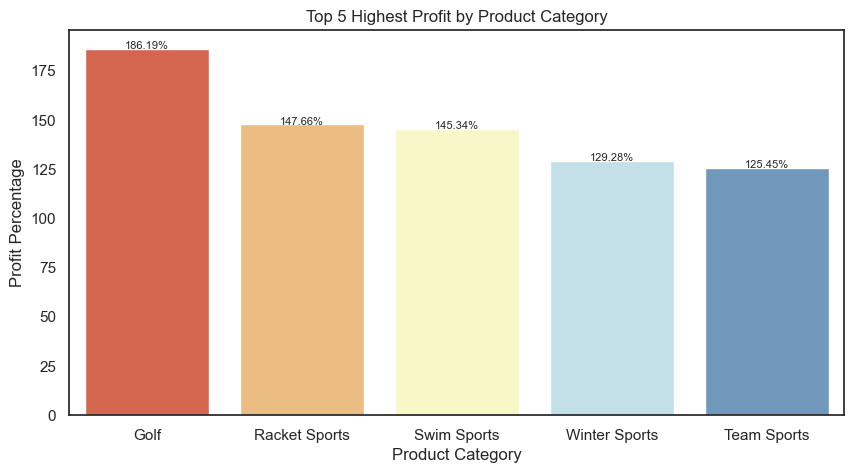

In [224]:
cat_high_profit = (
    order_df
        .join(product_df['Product ID', 'Product Category', 'Product Name'], 'Product ID', 'inner')
        .withColumn('Profit Percentage', round((col('Profit')/(col('Cost Price Per Unit')*col('Quantity Ordered'))*100), 2))
        .groupBy('Product Category')
        .agg(avg('Profit Percentage').alias('Profit Percentage'))
        .orderBy(desc('Profit Percentage'))
        .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(x='Product Category', y='Profit Percentage', data=cat_high_profit.head(), palette='RdYlBu')

for i in range(cat_high_profit.head().shape[0]):
  plt.text(i, cat_high_profit.iloc[i]['Profit Percentage'],\
           f"{cat_high_profit.iloc[i]['Profit Percentage']:.2f}%", ha='center', fontsize=8)

plt.title("Top 5 Highest Profit by Product Category")
plt.show()

From the 12 product categories available, the top five with the highest profit are Golf, Racket Sports, Swim Sports, Winter Sports, and Team Sports. The Golf category has the highest profit percentage at 186.19%. The calculation is based on the average profit margin per unit cost price. Nonetheless, let's delve deeper into why this category generates a higher profit compared to the others.

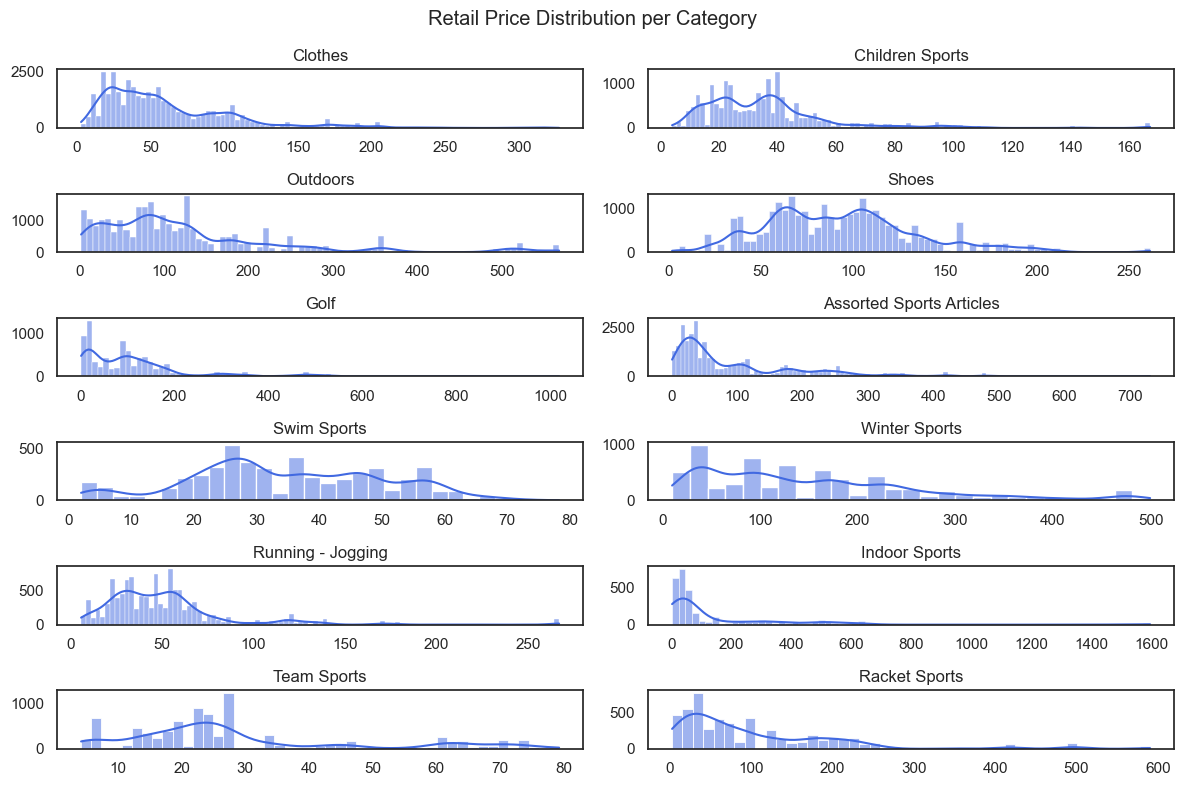

In [249]:
merge = (order_df
        .join(product_df.select('Product ID', 'Product Category', 'Product Name'), 'Product ID', 'inner')
        .toPandas()
)

# Get a list of unique product categories
categories = merge['Product Category'].unique()

# Create subplots for each category
n_categories = len(categories)
n_cols = 2
n_rows = (n_categories - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
axes = axes.flatten()

# Plot histograms with KDE for each category
for i, category in enumerate(categories):
    ax = axes[i]
    sns.histplot(merge[merge['Product Category'] == category]['Retail Price'], kde=True, ax=ax, color='royalblue')
    ax.set_title(category)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle('Retail Price Distribution per Category')
plt.tight_layout()
plt.show()

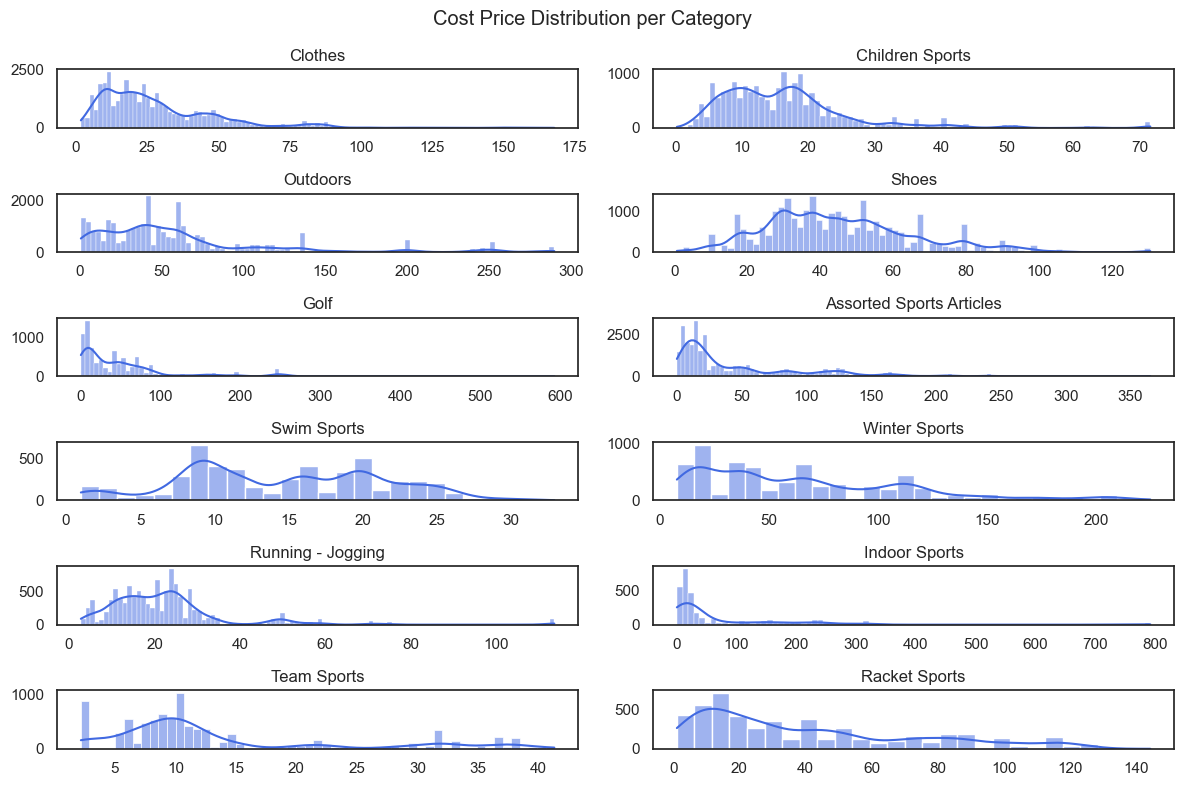

In [250]:
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
axes = axes.flatten()

# Plot histograms with KDE for each category
for i, category in enumerate(categories):
    ax = axes[i]
    sns.histplot(merge[merge['Product Category'] == category]['Cost Price Per Unit'], kde=True, ax=ax, color='royalblue')
    ax.set_title(category)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle('Cost Price Distribution per Category')
plt.tight_layout()
plt.show()

By comparing the histogram of Retail Price and Cost Price, we can see how the price distributions vary between different product categories. For example, if one histogram has a peak at a lower price point than another, this suggests that products in that category tend to be cheaper. 

We can also look for patterns within individual histograms. For example, if a histogram has two peaks (a bimodal distribution), this could suggest that there are two distinct groups of products within that category with different price points.

From that point, is there a correlation between lower costs and higher profits, or does a lower price equate to higher customer demand?

### Does the lower the cost, the higher the profit? Does the cheaper the price the more people buy?

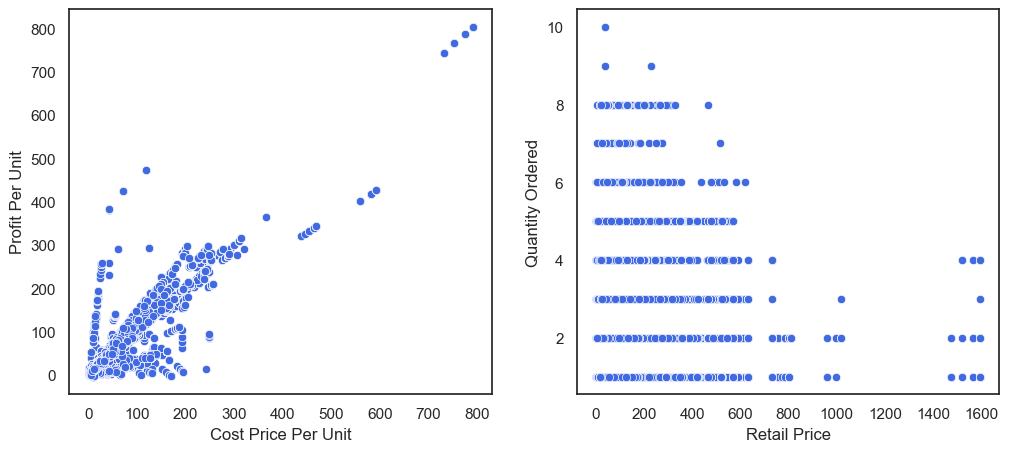

In [244]:
# Select specific columns from the dataframe
price_corr = (
    order_df
        .select('Quantity Ordered', 'Cost Price Per Unit', 'Profit', 'Retail Price')
        .withColumn('Profit Per Unit', round(col('Profit')/col('Quantity Ordered'), 2))
        .toPandas()
)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Create a scatter plot of 'Cost Price Per Unit' vs 'Profit'
sns.scatterplot(x='Cost Price Per Unit', y='Profit Per Unit', data=price_corr, ax=axes[0], color='royalblue')

# Create a scatter plot of 'Unit Price' vs 'Quantity Ordered'
sns.scatterplot(x='Retail Price', y='Quantity Ordered', data=price_corr, ax=axes[1], color='royalblue')

# Display the plots
plt.show()

- **Does the lower the cost, the higher the profit?** The scatter plot on the left shows a clear positive relationship between cost price per unit and profit. This suggests that a higher cost price per unit tends to result in a higher profit. However, there appear to be several outliers in the data, where low cost values are associated with high profits. This certainly warrants further analysis, such as examining the supply and demand at these values. There are many other factors that could produce such outlier values.

- **Does the cheaper the price the more people buy?** The scatter plot on the right shows the relationship between unit price and quantity ordered. There isn’t a clear relationship visible. It seems there’s a slight increase in quantity ordered as unit price increases, but it’s not a strong relationship. And the highest quantity ordered appears to be 10 units, with a small unit price, indicating a low volume of purchases. This suggests that factors other than price might be influencing the quantity ordered.

### Which products have generated the most profit and least profit?

In [294]:
prod_high_profit = (
    order_df
        .join(product_df['Product ID', 'Product Category', 'Product Name'], 'Product ID', 'inner')
        .groupBy('Product ID', 'Product Name')
        .agg(round(sum('Profit'),2).alias('Profit'),
             round(sum('Total Retail Price for This Order'),2).alias('Total Revenue'),
             sum('Quantity Ordered').alias('Total Sold'))
        .withColumn('Pct', round(col('Profit')/(order_df.agg(sum('Profit')).first()[0])*100 ,2))
        .orderBy(desc('Profit'))
)

prod_high_profit.show(10)

+------------+--------------------+---------+-------------+----------+----+
|  Product ID|        Product Name|   Profit|Total Revenue|Total Sold| Pct|
+------------+--------------------+---------+-------------+----------+----+
|230100700008|    Family Holiday 4| 282460.5|     551186.6|      1078|2.07|
|230100700011|         Hurricane 4|194804.15|     331534.9|      1208|1.43|
|230100700009|    Family Holiday 6| 139843.2|     285630.0|       510|1.03|
|230100700004|   Expedition Dome 3| 123326.0|     275760.0|       766|0.91|
|230100700002|     Comfort Shelter| 106420.0|     275440.0|      1252|0.78|
|220200100099|Big Guy Men's Air...|  88019.6|     176262.6|      1117|0.65|
|230100500082|Lucky Tech Interg...|  81742.5|     152707.1|      1211| 0.6|
|230100500077|Jl Legacy Curig I...|  62957.0|     108644.0|       628|0.46|
|240100400151|Weston F4 Men's H...| 60979.05|     121929.0|       291|0.45|
|230100600005|Basic 10, Left , ...|  59007.6|     115002.8|       886|0.43|
+-----------

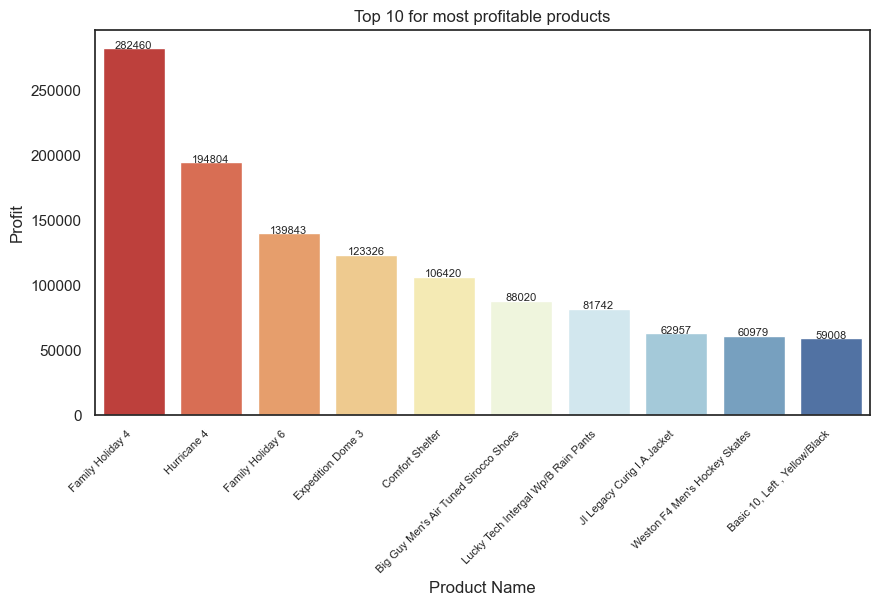

In [328]:
fig_4 = prod_high_profit.toPandas()

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Product Name', y='Profit', data=fig_4.head(10), palette='RdYlBu')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8, horizontalalignment='right')

for i in range(fig_4.head(10).shape[0]):
  plt.text(i, fig_4.iloc[i]['Profit'],\
           f"{fig_4.iloc[i]['Profit']:.0f}", ha='center', fontsize=8)

plt.title("Top 10 for most profitable products")
plt.show()

**Product Performance:** The product that generated the most profit is “Family Holiday 4” with a profit of 282,460. This indicates that “Family Holiday 4” is the most profitable product and might be the most popular or highest selling product among customers.

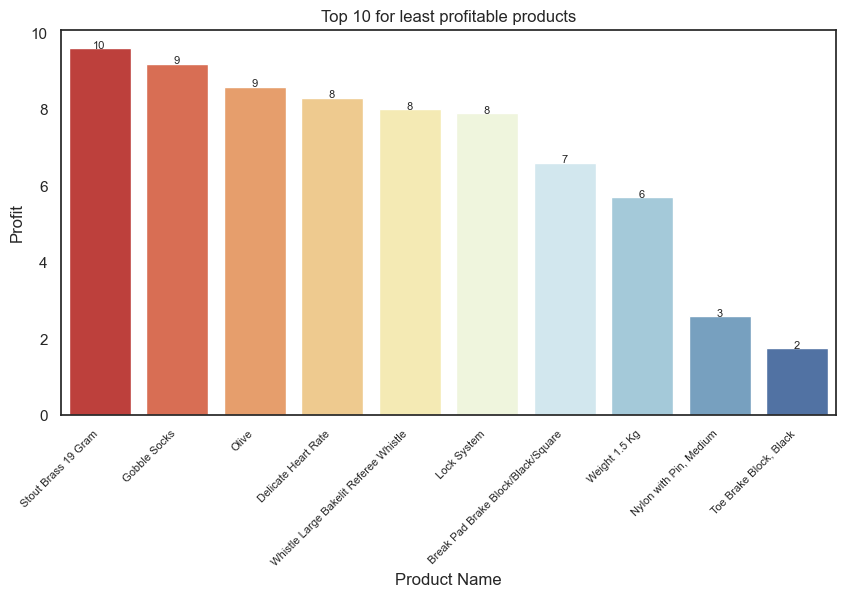

In [329]:
low_profit = fig_4.tail(10)

plt.figure(figsize=(10, 5))

ax2 = sns.barplot(x='Product Name', y='Profit', data=low_profit, palette='RdYlBu')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8, horizontalalignment='right')

# Add profit values as annotations using ax2
for i in range(low_profit.shape[0]):
    ax2.text(i, low_profit.iloc[i]['Profit'], f"{low_profit.iloc[i]['Profit']:.0f}", ha='center', fontsize=8)

plt.title("Top 10 for least profitable products")
plt.show()

**Least Profitable Product:** On the other hand, “Toe Brake Block, Black” generated the least profit, amounting to $2. This suggests that this product might not be as popular or it could be priced lower than other products or this is a new product, so we need more analyze from this point.

### Find the tendency and the longest of order-to-delivery length for every month in the latest year

In [337]:
delivery_length = (
    order_df
        .filter(col('Year') == order_df.agg(max('Year')).first()[0])
        .withColumn('order_to_delivery_length', datediff('Delivery Date', 'Date Order was placed'))
        .groupBy('Month')
        .agg(round(median('order_to_delivery_length')).alias('Delivery Length'),
             max('order_to_delivery_length').alias('The Longest Delivery Length'))
        .orderBy('Month')
        .show()
)

+-----+---------------+---------------------------+
|Month|Delivery Length|The Longest Delivery Length|
+-----+---------------+---------------------------+
|    1|            0.0|                         20|
|    2|            0.0|                         20|
|    3|            0.0|                         23|
|    4|            0.0|                         19|
|    5|            0.0|                         18|
|    6|            0.0|                         16|
|    7|            0.0|                         21|
|    8|            0.0|                         17|
|    9|            0.0|                         21|
|   10|            0.0|                         22|
|   11|            0.0|                         24|
|   12|            0.0|                         25|
+-----+---------------+---------------------------+



The longest order-to-delivery length for every month in the latest year is shown in the right column of the table. The longest order-to-delivery length is 25.5 days in December. The tendency of order-to-delivery length is that it increases as the months progress.

The proper measure of central tendency to use here would be the median, as it is less affected by outliers. The median order-to-delivery length for each month is 0, which leads us to conclude that the delivery of goods is extremely fast, taking less than one day, essentially resulting in instant delivery. However, it’s important to note that there are inevitably some delayed deliveries due to various external factors or peak seasons. This analysis underscores the efficiency of the delivery system while also acknowledging the potential for occasional delays.

### The owner of store want to give discount promo. But, the promo is only for the active loyal customer. Find the unique customer ID of loyal customers and show the proportion of their status. Definition of active loyal customer is the customer who order more than 3 times and order in 3 latest months.

In [399]:
active_customer = (
    order_df
        .withColumn('Status Map', when(col('Customer Status') == 'Silver', 1)
                                 .when(col('Customer Status') == 'Gold', 2)
                                 .when(col('Customer Status') == 'Platinum', 3)
                                 .otherwise(col('Customer Status')))
        .groupBy('Customer ID')
        .agg(max('Status Map').alias('Current Status'))
)

loyal_customer = (
    order_df
        .filter(col('Year') == order_df.agg(max('Year')).first()[0])
        .filter(col('Month').isin(10,11,12))
        .groupBy('Customer ID')
        .agg(count('Order ID').alias('Total Order'))
        .where('`Total Order` > 3')
        .join(active_customer['Customer ID', 'Current Status'], 'Customer ID', 'inner')
)

print(f"Total active loyal customers: {loyal_customer.count()}\n")

loyal_customer.sort('Total Order', ascending=False).show(10)

Total active loyal customers: 103



+-----------+-----------+--------------+
|Customer ID|Total Order|Current Status|
+-----------+-----------+--------------+
|      47467|         10|             2|
|       1244|          7|             3|
|        870|          6|             2|
|      62720|          6|             2|
|      52537|          6|             3|
|      63003|          6|             2|
|      81108|          6|             2|
|      83407|          6|             2|
|      92311|          6|             2|
|      25455|          5|             2|
+-----------+-----------+--------------+
only showing top 10 rows



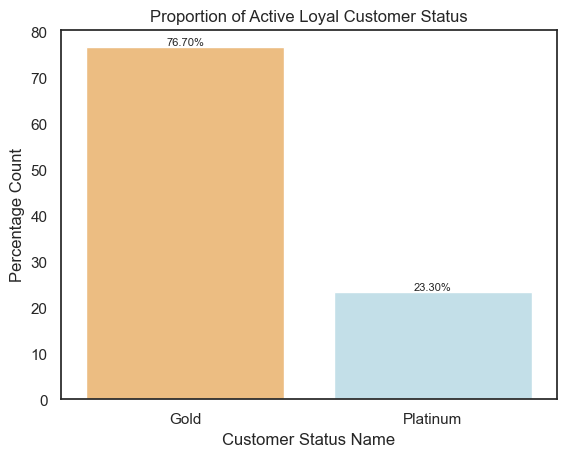

In [403]:
fig_5 = loyal_customer.toPandas()

status_dict = {"1": 'Silver', "2": 'Gold', "3": 'Platinum'}
fig_5['Customer Status'] = fig_5['Current Status'].map(status_dict)

# Get the normalized value counts
status_counts = fig_5['Customer Status'].value_counts(normalize=True)

# Create the bar plot
sns.barplot(x=status_counts.index, y=(status_counts.values*100), palette='RdYlBu')

# Add annotations
for i, count in enumerate(status_counts.values * 100):
    plt.text(i, count, f'{count:.2f}%', ha='center', va='bottom', fontsize=8)

# Set the title and labels
plt.title('Proportion of Active Loyal Customer Status')
plt.xlabel('Customer Status Name')
plt.ylabel('Percentage Count')

# Show the plot
plt.show()

Based on the bar graph, we can interpret that the majority of active loyal customers are of Gold status, making up approximately 76.7% of the total. This is followed by Platinum status customers at around 23.3%.

And we have successfully identified a total of 103 active customers who meet the criteria of having placed orders in the last three months and having ordered more than three times within that period. Therefore, we can implement a discount promo strategy for these customers based on their highest segmentation status.

#### FIN